In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error

Step 1: Load and Inspect the Dataset
Load the dataset and display the first few rows to understand its structure.

In [2]:
file_path = '/home/antqua/code/AntQua/ET_Predictor/raw_data/scrubbed.csv'
data = pd.read_csv(file_path, low_memory=False)

data.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [3]:
print(data.shape)
print(data.columns)
print(data.dtypes)

(80332, 11)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')
datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object


The dataset has several columns, including datetime, city, state, country, shape, duration (seconds), duration (hours/min), comments, date posted, latitude, and longitude. Our focus will be on the datetime and duration (seconds) columns for features, and latitude and longitude for the target variables.

Step 2: Data Preparation

Convert the datetime column to numerical format and split it into separate features
We'll convert the datetime column to datetime objects and then extract the year, month, day, hour, and minute as separate features.

Handle Missing Values
We'll check for and handle any missing values in the relevant columns (datetime, duration (seconds), latitude, and longitude).

In [4]:
# Strip whitespace from all column names
data.columns = data.columns.str.strip()

# Convert latitude and longitude to numeric, forcing invalid parsing to NaN
data['latitude'] = pd.to_numeric(data['latitude'], errors='coerce')
data['longitude'] = pd.to_numeric(data['longitude'], errors='coerce')

# Convert duration (seconds) to numeric, forcing invalid parsing to NaN
data['duration (seconds)'] = pd.to_numeric(data['duration (seconds)'], errors='coerce')

# Convert datetime column to datetime object
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')

# Drop rows where datetime conversion failed
data = data.dropna(subset=['datetime'])

# Drop rows with NaN 
data = data.dropna()

print(data.shape)
print(data.columns)
# # Verify the conversion
print(data.dtypes)

(66040, 11)
Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude'],
      dtype='object')
datetime                datetime64[ns]
city                            object
state                           object
country                         object
shape                           object
duration (seconds)             float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                       float64
longitude                      float64
dtype: object


Step 3: Feature Engineering

We'll use the extracted datetime features and the duration (seconds) for training the model.

In [5]:
us_data = data[data['country'] == 'us']

# Save the filtered data to a new CSV file
# us_only_file_path = '/mnt/data/us_only_scrubbed.csv'
# us_data.to_csv(us_only_file_path, index=False)

#import ace_tools as tools; tools.display_dataframe_to_user(name="US Only Scrubbed Dataset", dataframe=us_data)
#us_only_file_path

us_data.shape

(63099, 11)

In [6]:
# Make an explicit copy of the DataFrame
us_data = us_data.copy()

# Extract year, month, day, hour, and minute from datetime
us_data['year'] = us_data['datetime'].dt.year
us_data['month'] = us_data['datetime'].dt.month
us_data['day'] = us_data['datetime'].dt.day
us_data['hour'] = us_data['datetime'].dt.hour
us_data['minute'] = us_data['datetime'].dt.minute

# Specify the columns to keep
#columns_to_keep = ['datetime', 'duration (seconds)', 'latitude', 'longitude', 'year', 'month', 'day', 'hour', 'minute']

# Select only the specified columns
#us_data = us_data.loc[:, columns_to_keep]

# Display the head, dtypes, and shape of the DataFrame
us_data_dtypes = us_data.dtypes
us_data_shape = us_data.shape

us_data_dtypes, us_data_shape


(datetime                datetime64[ns]
 city                            object
 state                           object
 country                         object
 shape                           object
 duration (seconds)             float64
 duration (hours/min)            object
 comments                        object
 date posted                     object
 latitude                       float64
 longitude                      float64
 year                             int32
 month                            int32
 day                              int32
 hour                             int32
 minute                           int32
 dtype: object,
 (63099, 16))

Step 4: Model Training

We'll scale the features and train both LinearRegression and RandomForestRegressor models for predicting latitude and longitude separately.

Keep just the enntries for the united states

In [7]:
# Define features and target variables
features = ['duration (seconds)', 'year', 'month', 'day', 'hour', 'minute']
X = us_data[features]
y_lat = us_data['latitude']
y_long = us_data['longitude']

# Split the data into training and test sets
X_train, X_test, y_lat_train, y_lat_test, y_long_train, y_long_test = train_test_split(X, y_lat, y_long, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Regressor models
rf_reg_lat = RandomForestRegressor(random_state=42)
rf_reg_lat.fit(X_train_scaled, y_lat_train)

rf_reg_long = RandomForestRegressor(random_state=42)
rf_reg_long.fit(X_train_scaled, y_long_train)


RandomForestRegressor(random_state=42)

Step 5: Prediction
We'll use the trained models to predict the location for a future chosen date.

In [8]:
# Predict and evaluate the models
y_lat_pred_rf = rf_reg_lat.predict(X_test_scaled)
y_long_pred_rf = rf_reg_long.predict(X_test_scaled)

mae_lat_rf = median_absolute_error(y_lat_test, y_lat_pred_rf)
mae_long_rf = median_absolute_error(y_long_test, y_long_pred_rf)

mae_results = {
    'Random Forest Latitude MAE': mae_lat_rf,
    'Random Forest Longitude MAE': mae_long_rf,
}

mae_results

{'Random Forest Latitude MAE': 3.683563900000003,
 'Random Forest Longitude MAE': 14.927904165500003}

In [31]:
# Example prediction for a future chosen date
future_date = pd.to_datetime('2024-10-04 00:00:00')
future_duration = 120  # example duration in seconds

future_features = pd.DataFrame({
    'duration (seconds)': [future_duration],
    'year': [future_date.year],
    'month': [future_date.month],
    'day': [future_date.day],
    'hour': [future_date.hour],
    'minute': [future_date.minute]
})

future_features_scaled = scaler.transform(future_features)

# Predict latitude and longitude using both models
predicted_lat_rf = rf_reg_lat.predict(future_features_scaled)
predicted_long_rf = rf_reg_long.predict(future_features_scaled)

predicted_location_rf = (predicted_lat_rf[0], predicted_long_rf[0])

print(f"Predicted location (Random Forest): {predicted_location_rf}")

Predicted location (Random Forest): (38.83951874225, -88.7385572336)


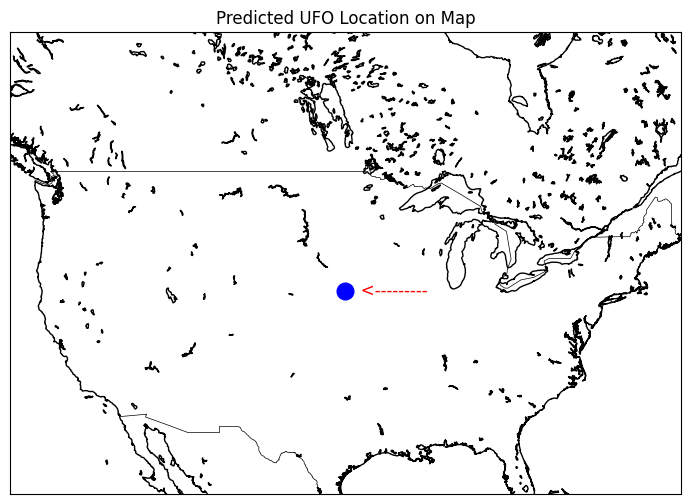

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

predicted_location_rf = (predicted_lat_rf, predicted_long_rf)

predicted_location_rf = (predicted_lat_rf, predicted_long_rf)

# Create a figure
plt.figure(figsize=(15, 6))

# Create a Basemap instance with a larger scale
m = Basemap(projection='merc', llcrnrlat=predicted_lat_rf-15, urcrnrlat=predicted_lat_rf+15,
            llcrnrlon=predicted_long_rf-30, urcrnrlon=predicted_long_rf+30, resolution='i')

# Draw coastlines and countries
m.drawcoastlines()
m.drawcountries()

# Convert latitude and longitude to map projection coordinates
x, y = m(predicted_long_rf, predicted_lat_rf)

# Plot the predicted location
m.plot(x, y, 'bo', markersize=12)
plt.text(x, y, '   <---------', fontsize=12, ha='left', va='center', color='red')

# Add title
plt.title('Predicted UFO Location on Map')

# Show the plot
plt.show()
